In [29]:
# Instala a biblioteca rasterio
!pip install rasterio

print("Biblioteca rasterio instalada com sucesso.")

Biblioteca rasterio instalada com sucesso.


In [30]:
# Célula 1: Instalação e Importação de Bibliotecas
!pip install spectral scikit-image scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import spectral as spy
from spectral.io import envi
from scipy.io import loadmat
from scipy import ndimage
import skimage.segmentation as segmentation
from skimage.util import img_as_float
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA

# Importa a biblioteca do Google Drive
from google.colab import drive

print("Bibliotecas carregadas com sucesso.")

Bibliotecas carregadas com sucesso.


In [31]:
# Célula 2: Montagem do Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive montado com sucesso em /content/drive")
except Exception as e:
    print(f"Erro ao montar o Google Drive: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado com sucesso em /content/drive


In [32]:
# Célula 3: Carregamento da Imagem Hiperespectral (do Drive)

import os
import zipfile
import tempfile
!pip install rasterio # Instala a biblioteca rasterio
import rasterio # Importa a biblioteca rasterio

# --- IMPORTANTE: EDITE A LINHA ABAIXO ---
# Clique no ícone de pasta à esquerda, navegue até sua pasta,
# clique nos três pontos e selecione "Copiar caminho".
seu_caminho_para_a_pasta = '/content/drive/MyDrive/ENMAP/ENMAP_L1B'
# ------------------------------------------------

# Variáveis para armazenar os dados
img_raw_list = []
file_paths_list = [] # Para armazenar os caminhos dos arquivos carregados (útil para depuração)

# Definir os sufixos dos arquivos que queremos carregar
SPECTRAL_SUFFIXES = ('SPECTRAL_IMAGE_VNIR.TIF', 'SPECTRAL_IMAGE_SWIR.TIF')

try:
    print(f"Procurando e analisando arquivos espectrais (.tif ou em .zip) em: {seu_caminho_para_a_pasta}")

    # Usar tempfile para extrair arquivos .tif de zips
    with tempfile.TemporaryDirectory() as tmpdir:
        for root, _, files in os.walk(seu_caminho_para_a_pasta):
            for file in files:
                full_path = os.path.join(root, file)

                # Processar arquivos .tif diretamente
                if file.upper().endswith(SPECTRAL_SUFFIXES):
                    print(f"\nAnalisando arquivo espectral .tif: {full_path}")
                    try:
                        with rasterio.open(full_path) as src:
                            print(f"  Tipo de arquivo (Driver): {src.driver}")
                            try:
                                img_raw = src.read() # Carrega todos os canais
                                # Rasterio lê como (bandas, altura, largura), pode precisar reordenar para (altura, largura, bandas)
                                img_raw = np.moveaxis(img_raw, 0, -1)
                                img_raw_list.append(img_raw)
                                file_paths_list.append(full_path)
                                print(f"  Carregado: {full_path} com dimensões: {img_raw.shape}")
                            except Exception as e:
                                print(f"  Erro ao carregar dados de {full_path} com rasterio: {e}")
                    except Exception as e:
                        print(f"  Erro ao abrir ou determinar o tipo de {full_path} com rasterio: {e}")

                # Processar arquivos .zip
                elif file.lower().endswith('.zip'):
                    print(f"\nEncontrado arquivo .zip: {full_path}")
                    try:
                        with zipfile.ZipFile(full_path, 'r') as zip_ref:
                            # Extrair apenas os arquivos .tif com os sufixos desejados do zip
                            for member in zip_ref.namelist():
                                if member.upper().endswith(SPECTRAL_SUFFIXES):
                                    extracted_path = os.path.join(tmpdir, os.path.basename(member))
                                    # Verifique se o arquivo já existe no tmpdir antes de extrair
                                    if not os.path.exists(extracted_path):
                                        with open(extracted_path, "wb") as outfile:
                                            outfile.write(zip_ref.read(member))
                                        print(f"  Extraído .tif espectral de zip para análise: {extracted_path}")

                                    # Tentar abrir com rasterio para verificar o driver (tipo) do arquivo extraído
                                    try:
                                        with rasterio.open(extracted_path) as src:
                                            print(f"  Tipo de arquivo (Driver): {src.driver}")
                                            try:
                                                img_raw = src.read() # Carrega todos os canais
                                                # Rasterio lê como (bandas, altura, largura), pode precisar reordenar para (altura, largura, bandas)
                                                img_raw = np.moveaxis(img_raw, 0, -1)
                                                img_raw_list.append(img_raw)
                                                file_paths_list.append(extracted_path)
                                                print(f"  Carregado: {extracted_path} com dimensões: {img_raw.shape}")
                                            except Exception as e:
                                                 print(f"  Erro ao carregar dados de {extracted_path} com rasterio: {e}")

                                    except Exception as e:
                                        print(f"  Erro ao abrir ou determinar o tipo de {extracted_path} com rasterio: {e}")

                    except Exception as e:
                        print(f"Erro ao processar arquivo zip {full_path}: {e}")


    if not img_raw_list:
        print("\n--- AVISO: NENHUM ARQUIVO SPECTRAL_IMAGE_VNIR.TIF OU SPECTRAL_IMAGE_SWIR.TIF FOI CARREGADO ---")
        print("Verifique se o caminho da pasta está correto e se contém arquivos .tif (diretamente ou em .zip) que terminam com 'SPECTRAL_IMAGE_VNIR.TIF' ou 'SPECTRAL_IMAGE_SWIR.TIF' e podem ser lidos por rasterio.")
    else:
        print("\nDados SPECTRAL_IMAGE_VNIR.TIF e SPECTRAL_IMAGE_SWIR.TIF carregados com sucesso!")
        print(f"Total de imagens espectrais carregadas: {len(img_raw_list)}")

        # Agora você tem uma lista de arrays numpy em img_raw_list, um para cada imagem .tif carregada.
        # Você pode acessar a primeira imagem assim:
        # first_img = img_raw_list[0]
        # print(f"Dimensões da primeira imagem (Altura, Largura, Bandas): {first_img.shape}")
        # E o caminho do arquivo correspondente:
        # print(f"Caminho da primeira imagem: {file_paths_list[0]}")

except Exception as e:
    print(f"\n--- ERRO GERAL DURANTE O PROCESSAMENTO ---")
    print(f"Erro: {e}")
    print("Pode ter ocorrido um erro inesperado durante a leitura dos arquivos ou processamento.")

Procurando e analisando arquivos espectrais (.tif ou em .zip) em: /content/drive/MyDrive/ENMAP/ENMAP_L1B

Encontrado arquivo .zip: /content/drive/MyDrive/ENMAP/ENMAP_L1B/ENMAP01-____L1B-DT0000150419_20250826T134808Z_015_V010502_20251024T024113Z.ZIP
  Extraído .tif espectral de zip para análise: /tmp/tmpoujusutx/ENMAP01-____L1B-DT0000150419_20250826T134808Z_015_V010502_20251024T024113Z-SPECTRAL_IMAGE_SWIR.TIF
  Tipo de arquivo (Driver): GTiff
  Carregado: /tmp/tmpoujusutx/ENMAP01-____L1B-DT0000150419_20250826T134808Z_015_V010502_20251024T024113Z-SPECTRAL_IMAGE_SWIR.TIF com dimensões: (1024, 1000, 133)
  Extraído .tif espectral de zip para análise: /tmp/tmpoujusutx/ENMAP01-____L1B-DT0000150419_20250826T134808Z_015_V010502_20251024T024113Z-SPECTRAL_IMAGE_VNIR.TIF
  Tipo de arquivo (Driver): GTiff
  Carregado: /tmp/tmpoujusutx/ENMAP01-____L1B-DT0000150419_20250826T134808Z_015_V010502_20251024T024113Z-SPECTRAL_IMAGE_VNIR.TIF com dimensões: (1024, 1000, 91)

Encontrado arquivo .zip: /content

In [33]:
# Célula 4.c: Remoção de Nuvens usando Máscara de Nuvens

import rasterio # Added this import statement

# Assumindo que a máscara de nuvens está em um arquivo .TIF separado
# e que o nome do arquivo contém 'CLOUD_MASK'.
# --- IMPORTANTE: EDITE A LINHA ABAIXO ---
# Clique no ícone de pasta à esquerda, navegue até a pasta com a máscara,
# clique nos três pontos e selecione "Copiar caminho".
caminho_para_mascara_nuvens = '/content/drive/MyDrive/ENMAP/ENMAP_L1B/ENMAP01-____L1B-DT0000150419_20250826T134808Z_015_V010502_20251024T024113Z-CLOUD_MASK.TIF' # Substitua pelo caminho real

# ------------------------------------------------

# Certifique-se de que a variável 'img_stacked' existe e não está vazia
if 'img_stacked' in locals() and img_stacked is not None:
    print("Iniciando remoção de nuvens da imagem empilhada...")

    try:
        # Carregar a máscara de nuvens
        with rasterio.open(caminho_para_mascara_nuvens) as src_mask:
            cloud_mask = src_mask.read(1) # Lê a primeira banda da máscara (assumindo que a máscara é uma única banda)
            print(f"Máscara de nuvens carregada com shape: {cloud_mask.shape}")

        # Verificar se as dimensões espaciais da máscara e da imagem empilhada são compatíveis
        if cloud_mask.shape == img_stacked.shape[:2]:
            # Criar uma máscara booleana: True para pixels NÃO nublados, False para pixels nublados
            # Assumindo que pixels com valor 1 na máscara de nuvens são nuvens, ajuste conforme a documentação da sua máscara
            # Exemplo: Se 0 = não nuvem, 1 = nuvem
            non_cloud_mask = (cloud_mask == 0)

            # Aplicar a máscara à imagem empilhada
            # Isso irá manter apenas os pixels que não são nuvens
            # Os pixels removidos podem ser substituídos por NaN ou um valor específico
            # Vamos criar uma nova imagem onde pixels nublados são definidos como NaN
            img_stacked_no_clouds = img_stacked.astype(np.float32) # Converter para float para permitir NaN
            img_stacked_no_clouds[~non_cloud_mask] = np.nan # Define pixels nublados como NaN

            print("Remoção de nuvens concluída.")
            print(f"Shape da imagem empilhada após remoção de nuvens: {img_stacked_no_clouds.shape}")

            # Agora, 'img_stacked_no_clouds' contém a imagem empilhada com pixels nublados definidos como NaN.
            # Você deve usar esta nova variável nas etapas subsequentes (normalização, denoising, etc.)
            # que usavam 'img_stacked'.

            # Nota: As etapas seguintes (normalização, denoising, PCA, SLIC, VCA, etc.)
            # precisarão ser adaptadas para lidar com valores NaN, por exemplo, ignorando-os
            # nos cálculos ou usando funções que os tratem adequadamente.

            # Exemplo: Você pode querer substituir 'img_stacked' por 'img_stacked_no_clouds'
            # para que as células seguintes usem a imagem sem nuvens.
            img_stacked = img_stacked_no_clouds
            print("Variável 'img_stacked' atualizada para a versão sem nuvens (com NaN).")


        else:
            print("Erro: As dimensões espaciais da máscara de nuvens e da imagem empilhada não correspondem.")
            print(f"Shape da Máscara: {cloud_mask.shape}")
            print(f"Shape da Imagem Empilhada: {img_stacked.shape[:2]}")

    except FileNotFoundError:
        print(f"Erro: Arquivo da máscara de nuvens não encontrado em: {caminho_para_mascara_nuvens}")
        print("Verifique se o caminho está correto.")
    except Exception as e:
        print(f"Erro ao carregar ou processar a máscara de nuvens: {e}")

else:
    print("Erro: A variável 'img_stacked' não foi criada ou está vazia. Execute a Célula 4.b primeiro.")

Iniciando remoção de nuvens da imagem empilhada...
Erro ao carregar ou processar a máscara de nuvens: /content/drive/MyDrive/ENMAP/ENMAP_L1B/ENMAP01-____L1B-DT0000150419_20250826T134808Z_015_V010502_20251024T024113Z-CLOUD_MASK.TIF: No such file or directory


In [34]:
# Célula 4.b: Empilhamento das Imagens SWIR e VNIR

# Certifique-se de que a lista 'img_raw_list' existe e não está vazia
if 'img_raw_list' in locals() and img_raw_list:
    print("Iniciando empilhamento das imagens SWIR e VNIR...")

    # Verifica se há pelo menos duas imagens na lista (assumindo que a ordem é VNIR e SWIR, ou vice-versa)
    # É importante garantir que as imagens sejam do mesmo tamanho espacial (altura x largura)
    if len(img_raw_list) >= 2:
        # Assumindo que a primeira imagem é VNIR e a segunda é SWIR (ou vice-versa)
        # Você pode precisar ajustar os índices [0] e [1] dependendo da ordem em que seus arquivos foram carregados
        img1 = img_raw_list[0] # Ex: VNIR
        img2 = img_raw_list[1] # Ex: SWIR

        # Verifica se as dimensões espaciais são compatíveis para empilhamento
        if img1.shape[:2] == img2.shape[:2]:
            try:
                # Empilha as bandas das duas imagens ao longo do eixo das bandas (eixo 2)
                img_stacked = np.dstack((img1, img2))
                print(f"Imagens empilhadas com sucesso. Nova forma: {img_stacked.shape}")

                # Agora, img_stacked contém a imagem combinada com todas as bandas VNIR e SWIR.
                # Você pode continuar o pré-processamento (normalização, etc.) nesta imagem empilhada.

                # Se você quiser substituir as imagens originais na lista pelo stack, pode fazer:
                # img_raw_list_stacked = [img_stacked]
                # print("Lista de imagens substituída pela imagem empilhada.")

                # Ou, se quiser manter as originais e ter o stack como uma nova variável:
                # A variável img_stacked já foi criada acima.
                pass # img_stacked já está disponível

                # Nota: As variáveis img_norm e img_denoised das células anteriores
                # foram calculadas por imagem individualmente. Você precisará recalcular
                # a normalização e remoção de ruído para a imagem empilhada se quiser
                # aplicar as etapas subsequentes (PCA, SLIC, VCA, etc.) nela.

                # Exemplo de como normalizar a imagem empilhada:
                # print("\nNormalizando imagem empilhada...")
                # h_stack, w_stack, b_stack = img_stacked.shape
                # img_stacked_norm = minmax_scale(img_stacked.reshape(-1, b_stack)).reshape(img_stacked.shape)
                # img_stacked_norm = img_stacked_norm.astype(np.float32)
                # print(f"Shape normalizado da imagem empilhada: {img_stacked_norm.shape}")

                # Agora você pode usar 'img_stacked_norm' nas células seguintes
                # que usam 'img_denoised' ou 'img_norm'.
                # Por exemplo, na Célula 5 (SLIC), você usaria 'img_stacked_norm' em vez de 'img_denoised'.
                # Você precisará adaptar as células subsequentes para usar 'img_stacked_norm'.


            except Exception as e:
                print(f"Erro ao empilhar as imagens: {e}")
        else:
            print("Erro: As imagens têm dimensões espaciais diferentes e não podem ser empilhadas.")
            print(f"Dimensões da Imagem 1: {img1.shape[:2]}")
            print(f"Dimensões da Imagem 2: {img2.shape[:2]}")

    else:
        print("Aviso: Não há imagens suficientes (pelo menos 2) na 'img_raw_list' para empilhar.")

else:
    print("Erro: A variável 'img_raw_list' não foi carregada ou está vazia. Execute a Célula 3 primeiro.")

Iniciando empilhamento das imagens SWIR e VNIR...
Imagens empilhadas com sucesso. Nova forma: (1024, 1000, 224)


Iniciando pré-processamento para a imagem empilhada...

--- Processando Imagem Empilhada ---
Etapa 1a: Iniciando Normalização e Remoção de Ruído
Shape original (empilhada): (1024, 1000, 224)
Shape normalizado (empilhada): (1024, 1000, 224)
Aplicando filtro de mediana para remoção de ruído (pode levar alguns segundos)...
Remoção de ruído concluída.

Visualizando composição RGB (Bandas: R=20, G=30, B=40)...


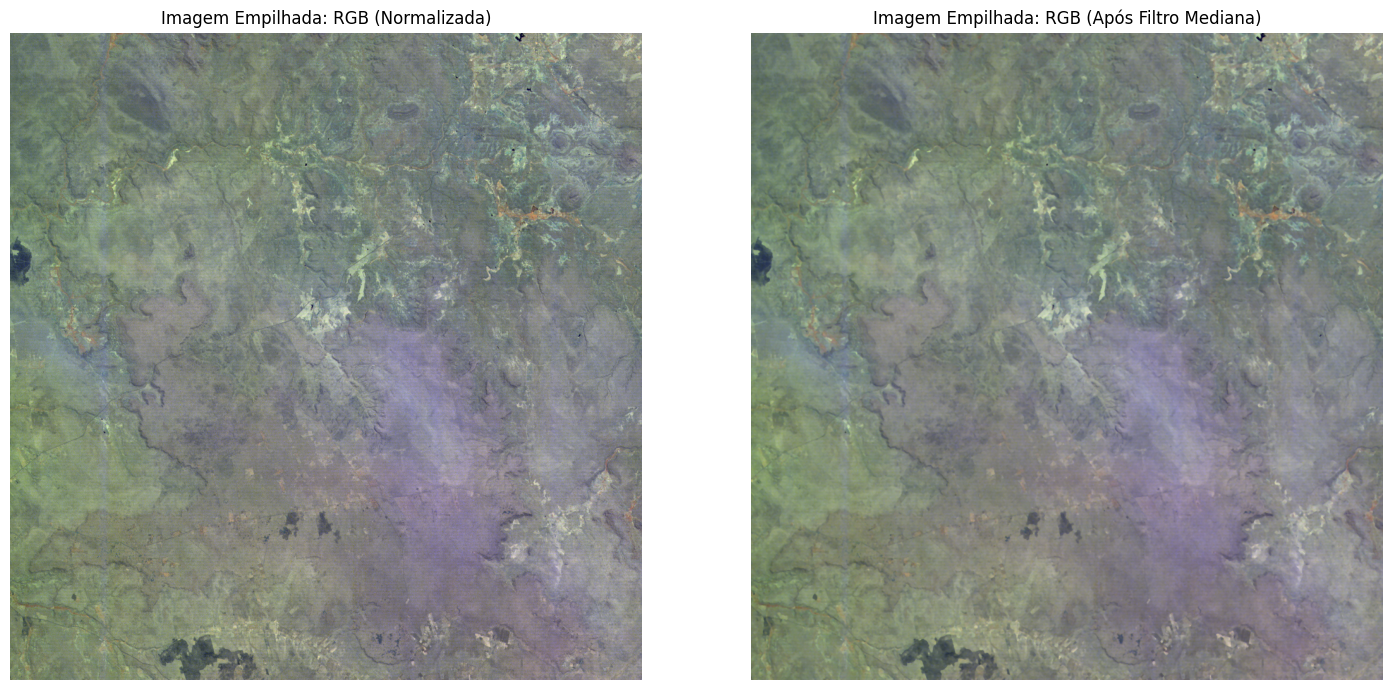


--- Processamento da imagem empilhada concluído. ---


In [35]:
# Célula 4: Etapa 1.a) Correção Atmosférica (Assumida) e Remoção de Ruído (PARA A IMAGEM EMPILHADA)

# Importa a biblioteca 'os' se ainda não foi importada (embora não seja mais essencial nesta célula)
import os

# Certifique-se de que a variável 'img_stacked' existe e não está vazia
if 'img_stacked' in locals() and img_stacked is not None:

    print("Iniciando pré-processamento para a imagem empilhada...")

    # A variável img_denoised_list não será mais uma lista, mas a única imagem empilhada processada
    # img_denoised_list = [] # Não é mais uma lista
    # img_norm_list = [] # Não é mais uma lista

    # Processa a imagem empilhada
    img_raw = img_stacked # Usamos img_stacked como a "imagem bruta" para esta célula

    print(f"\n--- Processando Imagem Empilhada ---")
    print("Etapa 1a: Iniciando Normalização e Remoção de Ruído")

    # 1. Normalização dos Dados
    # Normaliza todas as bandas para o intervalo [0, 1]
    try:
        h, w, b = img_raw.shape
        img_norm = minmax_scale(img_raw.reshape(-1, b)).reshape(img_raw.shape)
        img_norm = img_norm.astype(np.float32)
        # img_norm_list.append(img_norm) # Não é mais uma lista

        print(f"Shape original (empilhada): {img_raw.shape}")
        print(f"Shape normalizado (empilhada): {img_norm.shape}")

        # 2. Remoção de Ruído Espectral (Filtro de Mediana Simples)
        # Isso aplica um filtro espacial 3x3 em CADA banda
        print("Aplicando filtro de mediana para remoção de ruído (pode levar alguns segundos)...")
        img_denoised = np.zeros_like(img_norm)
        for j in range(b):
            img_denoised[:, :, j] = ndimage.median_filter(img_norm[:, :, j], size=3)

        print("Remoção de ruído concluída.")
        # img_denoised_list.append(img_denoised) # Não é mais uma lista
        # A variável img_denoised agora contém a imagem empilhada e processada


        # Visualização de uma banda (Antes e Depois)
        # Use uma banda que faça sentido para a visualização da imagem empilhada
        # Pode ser uma banda VNIR ou SWIR, ou uma combinação RGB
        # Vamos tentar visualizar um RGB simples usando bandas do VNIR (assumindo que estão nas primeiras 91 bandas)
        # Se suas bandas estiverem em outra ordem ou se quiser usar bandas SWIR, ajuste os índices
        try:
            # Tenta visualizar RGB usando bandas 30 (Azul), 20 (Verde), 10 (Vermelho) - Exemplo para VNIR
            # Estes índices podem precisar de ajuste dependendo da sua imagem ENMAP e da ordem das bandas
            banda_r = 20 # Exemplo de banda para o Vermelho (ajuste)
            banda_g = 30 # Exemplo de banda para o Verde (ajuste)
            banda_b = 40 # Exemplo de banda para o Azul (ajuste)

            if b >= max(banda_r, banda_g, banda_b):
                 print(f"\nVisualizando composição RGB (Bandas: R={banda_r}, G={banda_g}, B={banda_b})...")
                 # Cria uma imagem RGB para visualização (precisa estar no intervalo [0, 1] ou [0, 255])
                 # Como img_norm e img_denoised estão normalizadas [0, 1], podemos usá-las diretamente
                 img_rgb_norm = img_norm[:,:,[banda_r, banda_g, banda_b]]
                 img_rgb_denoised = img_denoised[:,:,[banda_r, banda_g, banda_b]]

                 plt.figure(figsize=(15, 7))

                 plt.subplot(1, 2, 1)
                 plt.imshow(img_rgb_norm)
                 plt.title(f'Imagem Empilhada: RGB (Normalizada)')
                 plt.axis('off')

                 plt.subplot(1, 2, 2)
                 plt.imshow(img_rgb_denoised)
                 plt.title(f'Imagem Empilhada: RGB (Após Filtro Mediana)')
                 plt.axis('off')

                 plt.tight_layout()
                 plt.show()
            else:
                print(f"Aviso: Não há bandas suficientes ({b}) para criar uma composição RGB com os índices especificados.")

        except Exception as e:
            print(f"Erro ao visualizar composição RGB: {e}")


    except Exception as e:
        print(f"Erro ao processar a imagem empilhada: {e}")

    print("\n--- Processamento da imagem empilhada concluído. ---")

else:
    # A mensagem de erro agora verifica a variável img_stacked
    print("Erro: A variável 'img_stacked' não foi criada ou está vazia. Execute a Célula 4.b primeiro.")

Etapa 1b: Iniciando Segmentação Espacial (SLIC) para a imagem empilhada
Calculando PCA...
Calculando Superpixels SLIC...
Segmentação concluída.


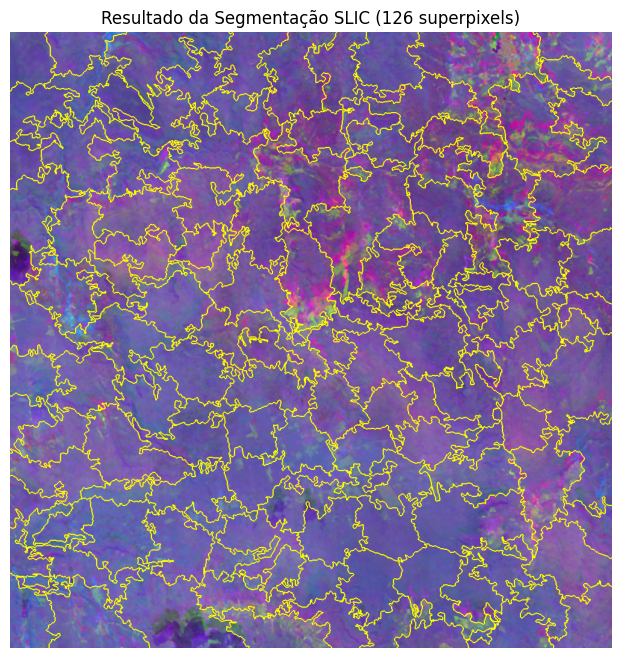

In [43]:
# Célula 5: Etapa 1.b) Segmentação Espacial Inicial (Superpixels - SLIC)

# Certifique-se de que a variável 'img_denoised' (a imagem empilhada sem ruído) existe e não está vazia
if 'img_denoised' in locals() and img_denoised is not None and img_denoised.size > 0:

    print("Etapa 1b: Iniciando Segmentação Espacial (SLIC) para a imagem empilhada")

    # Usamos a imagem empilhada e processada diretamente
    img_to_segment = img_denoised

    h, w, b = img_to_segment.shape

    # 1. Reduzir dimensionalidade para o SLIC (usando os 3 primeiros PCs)
    print("Calculando PCA...")
    img_reshaped = img_to_segment.reshape(-1, b)

    # Verifique se há amostras suficientes para o PCA (precisa de pelo menos 3)
    if img_reshaped.shape[0] < 3 or b < 3:
         print(f"  Aviso: Imagem tem dimensões insuficientes ({img_to_segment.shape}) para PCA 3D. Pulando segmentação SLIC.")
         # Defina segments_slic como None ou um array vazio para indicar que a segmentação não ocorreu
         segments_slic = None
    else:
        try:
            pca = PCA(n_components=3)
            img_pca = pca.fit_transform(img_reshaped)

            # Normalizar os 3 PCs para o intervalo [0, 1] (necessário para o SLIC)
            img_pca_rescaled = minmax_scale(img_pca).reshape(h, w, 3)

            # 2. Aplicar SLIC
            # n_segments: Número desejado de superpixels (ajuste conforme sua imagem)
            # compactness: Balanço entre cor (espectro) e espaço (proximidade)
            print("Calculando Superpixels SLIC...")

            segments_slic = segmentation.slic(
                img_pca_rescaled,
                n_segments=200,   # Ajuste este valor
                compactness=10,   # Ajuste este valor
                sigma=1,
                start_label=1,
                channel_axis=2 # Especifique o eixo dos canais explicitamente
            )

            # 3. Visualizar os segmentos
            print("Segmentação concluída.")
            plt.figure(figsize=(8, 8))
            # 'mark_boundaries' desenha as bordas dos segmentos sobre a imagem
            # Certifique-se de que a imagem usada para visualização tem 3 canais (RGB)
            plt.imshow(segmentation.mark_boundaries(img_pca_rescaled, segments_slic))
            plt.title(f'Resultado da Segmentação SLIC ({len(np.unique(segments_slic))} superpixels)')
            plt.axis('off')
            plt.show()

            # A variável segments_slic agora contém o mapa de segmentação para a imagem empilhada.

        except Exception as e:
            print(f"  Erro ao aplicar SLIC: {e}")
            # Em caso de erro, defina segments_slic como None para evitar problemas nas próximas células
            segments_slic = None


else:
    print("Erro: A variável 'img_denoised' não foi criada ou está vazia. Execute a Célula 4 primeiro.")
    # Em caso de erro, defina segments_slic como None para evitar problemas nas próximas células
    segments_slic = None

In [37]:
# Instala a biblioteca scikit-hyperspectral
!pip install scikit-hyperspectral

print("Biblioteca scikit-hyperspectral instalada com sucesso.")

ERROR: Could not find a version that satisfies the requirement scikit-hyperspectral (from versions: none)
ERROR: No matching distribution found for scikit-hyperspectral
Biblioteca scikit-hyperspectral instalada com sucesso.


Etapa 2a: Iniciando Extração de Endmembers Globais (VCA) usando a função personalizada
Formato dos dados para VCA global (personalizado): (224, 1024000)
Executando VCA (função personalizada) para encontrar 15 endmembers globais...
SNR estimated = 40.20962142944336[dB]
... Select the projective proj.

Extração global (personalizado) concluída.
Formato do pool de endmembers globais (personalizado): (15, 224)


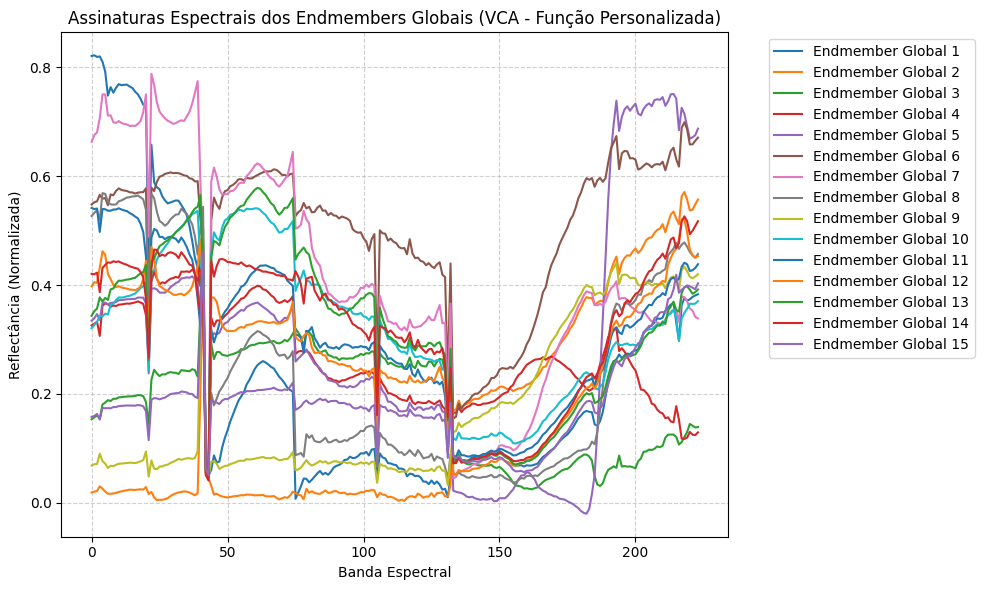

In [45]:
# Célula 6: Etapa 2.a) Extração de Endmembers Globais (VCA) usando a função personalizada
# -*- coding: utf-8 -*-
import sys
import numpy as np


#############################################
# Internal functions
#############################################

def estimate_snr(Y,r_m,x):

  [L, N] = Y.shape           # L number of bands (channels), N number of pixels
  [p, N] = x.shape           # p number of endmembers (reduced dimension)

  P_y     = np.sum(Y**2)/float(N)
  P_x     = np.sum(x**2)/float(N) + np.sum(r_m**2)
  snr_est = 10*np.log10( (P_x - p/L*P_y)/(P_y - P_x) )

  return snr_est



def vca(Y,R,verbose = True,snr_input = 0):
# Vertex Component Analysis
#
# Ae, indice, Yp = vca(Y,R,verbose = True,snr_input = 0)
#
# ------- Input variables -------------
#  Y - matrix with dimensions L(channels) x N(pixels)
#      each pixel is a linear mixture of R endmembers
#      signatures Y = M x s, where s = gamma x alfa
#      gamma is a illumination perturbation factor and
#      alfa are the abundance fractions of each endmember.
#  R - positive integer number of endmembers in the scene
#
# ------- Output variables -----------
# Ae     - estimated mixing matrix (endmembers signatures)
# indice - pixels that were chosen to be the most pure
# Yp     - Data matrix Y projected.
#
# ------- Optional parameters---------
# snr_input - (float) signal to noise ratio (dB)
# v         - [True | False]
# ------------------------------------
#
# Author: Adrien Lagrange (adrien.lagrange@enseeiht.fr)
# This code is a translation of a matlab code provided by
# Jose Nascimento (zen@isel.pt) and Jose Bioucas Dias (bioucas@lx.it.pt)
# available at http://www.lx.it.pt/~bioucas/code.htm under a non-specified Copyright (c)
# Translation of last version at 22-February-2018 (Matlab version 2.1 (7-May-2004))
#
# more details on:
# Jose M. P. Nascimento and Jose M. B. Dias
# "Vertex Component Analysis: A Fast Algorithm to Unmix Hyperspectral Data"
# submited to IEEE Trans. Geosci. Remote Sensing, vol. .., no. .., pp. .-., 2004
#
#

  #############################################
  # Initializations
  #############################################
  if len(Y.shape)!=2:
    sys.exit('Input data must be of size L (number of bands i.e. channels) by N (number of pixels)')

  [L, N]=Y.shape   # L number of bands (channels), N number of pixels

  R = int(R)
  if (R<0 or R>L):
    sys.exit('ENDMEMBER parameter must be integer between 1 and L')

  #############################################
  # SNR Estimates
  #############################################

  if snr_input==0:
    y_m = np.mean(Y,axis=1,keepdims=True)
    Y_o = Y - y_m           # data with zero-mean
    Ud  = np.linalg.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:R]  # computes the R-projection matrix
    x_p = np.dot(Ud.T, Y_o)                 # project the zero-mean data onto p-subspace

    SNR = estimate_snr(Y,y_m,x_p);

    if verbose:
      print("SNR estimated = {}[dB]".format(SNR))
  else:
    SNR = snr_input
    if verbose:
      print("input SNR = {}[dB]\n".format(SNR))

  SNR_th = 15 + 10*np.log10(R)

  #############################################
  # Choosing Projective Projection or
  #          projection to p-1 subspace
  #############################################

  if SNR < SNR_th:
    if verbose:
      print("... Select proj. to R-1")

    d = R-1
    if snr_input==0: # it means that the projection is already computed
      Ud = Ud[:,:d]
    else:
      y_m = np.mean(Y,axis=1,keepdims=True)
      Y_o = Y - y_m  # data with zero-mean

      Ud  = np.linalg.svd(np.dot(Y_o,Y_o.T)/float(N))[0][:,:d]  # computes the p-projection matrix
      x_p =  np.dot(Ud.T,Y_o)                 # project thezeros mean data onto p-subspace

    Yp =  np.dot(Ud,x_p[:d,:]) + y_m      # again in dimension L

    x = x_p[:d,:] #  x_p =  Ud.T * Y_o is on a R-dim subspace
    c = np.amax(np.sum(x**2,axis=0))**0.5
    y = np.vstack(( x, c*np.ones((1,N)) ))
  else:
    if verbose:
      print("... Select the projective proj.")

    d = R
    Ud  = np.linalg.svd(np.dot(Y,Y.T)/float(N))[0][:,:d] # computes the p-projection matrix

    x_p = np.dot(Ud.T,Y)
    Yp =  np.dot(Ud,x_p[:d,:])      # again in dimension L (note that x_p has no null mean)

    x =  np.dot(Ud.T,Y)
    u = np.mean(x,axis=1,keepdims=True)        #equivalent to  u = Ud.T * r_m
    y =  x / ( np.dot(u.T,x) + 1e-7 )


  #############################################
  # VCA algorithm
  #############################################

  indice = np.zeros((R),dtype=int)
  A = np.zeros((R,R))
  A[-1,0] = 1

  for i in range(R):
    w = np.random.rand(R,1);
    f = w - np.dot(A,np.dot(np.linalg.pinv(A),w))
    f = f / np.linalg.norm(f)

    v = np.dot(f.T,y)

    indice[i] = np.argmax(np.absolute(v))
    A[:,i] = y[:,indice[i]]        # same as x(:,indice(i))

  Ae = Yp[:,indice]

  return Ae,indice,Yp

# Certifique-se de que a variável img_denoised existe (agora é a imagem empilhada processada)
if 'img_denoised' in locals() and img_denoised is not None:
    print("Etapa 2a: Iniciando Extração de Endmembers Globais (VCA) usando a função personalizada")
    h, w, b = img_denoised.shape

    # 1. Preparar dados para o VCA (formato: bandas x pixels)
    # A função vca que você forneceu espera os dados neste formato (L, N)
    # Usamos a imagem empilhada e processada (img_denoised)
    data_vca_global_custom = img_denoised.reshape(-1, b).T
    print(f"Formato dos dados para VCA global (personalizado): {data_vca_global_custom.shape}")

    # 2. Definir o número de endmembers globais a extrair
    p_global = 15

    # 3. Executar a função VCA personalizada
    print(f"Executando VCA (função personalizada) para encontrar {p_global} endmembers globais...")
    # A função vca retorna os endmembers, os índices e os dados projetados
    # Agora, data_vca_global_custom tem 224 bandas, então os endmembers terão 224 bandas
    endmembers_global_custom, indices_vca_global_custom, Yp = vca(data_vca_global_custom, p_global)


    # 4. Os endmembers já estão no formato correto (p_global, n_bandas) a partir da saída da função
    # A saída da função VCA é (n_bandas, p_global), precisamos transpor para (p_global, n_bandas)
    endmembers_global_custom_transposed = endmembers_global_custom.T


    print(f"\nExtração global (personalizado) concluída.")
    # O shape agora será (p_global, 224)
    print(f"Formato do pool de endmembers globais (personalizado): {endmembers_global_custom_transposed.shape}") # (p_global, n_bandas)

    # 5. Visualizar os endmembers globais
    plt.figure(figsize=(10, 6))
    for i in range(endmembers_global_custom_transposed.shape[0]):
        plt.plot(endmembers_global_custom_transposed[i, :], label=f'Endmember Global {i+1}')
    plt.title('Assinaturas Espectrais dos Endmembers Globais (VCA - Função Personalizada)')
    plt.xlabel('Banda Espectral')
    plt.ylabel('Reflectância (Normalizada)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

else:
    print("Erro: A variável 'img_denoised' não foi criada ou é None. Execute as células anteriores.")

In [52]:
# Célula 7: Etapa 2.b) Extração Multiescala (Endmembers Locais por Superpixel)

# Certifique-se de que as variáveis img_denoised (imagem empilhada processada) e segments_slic existem
# Note que segments_slic deve ser o resultado da segmentação na imagem empilhada
if 'img_denoised' in locals() and img_denoised is not None and 'segments_slic' in locals() and segments_slic is not None:
    print("Etapa 2b: Iniciando Extração Multiescala (Endmembers Locais por Superpixel)")

    h, w, b = img_denoised.shape
    unique_segments = np.unique(segments_slic)
    num_segments = len(unique_segments)

    print(f"Total de superpixels encontrados: {num_segments}")

    # Dicionário para armazenar os endmembers locais por ID de superpixel
    local_endmembers_dict = {}
    local_indices_dict = {} # Opcional: para armazenar os índices dos pixels puros locais

    # Definir o número de endmembers locais a extrair por superpixel
    # Este é outro hiperparâmetro. Pode ser um valor fixo ou baseado no tamanho/variância do superpixel.
    # Vamos começar com um valor pequeno, por exemplo, 2 ou 3 endmembers por superpixel.
    # Ajuste este valor conforme necessário.
    p_local = 3

    print(f"Extraindo até {p_local} endmembers locais por superpixel...")

    # Use tqdm para mostrar o progresso se tiver muitas iterações
    # from tqdm.notebook import tqdm
    # for segment_id in tqdm(unique_segments, desc="Processando Superpixels"):

    for segment_id in unique_segments:
        # Criar uma máscara para o superpixel atual
        mask = (segments_slic == segment_id)

        # Extrair os pixels que pertencem a este superpixel
        # A função vca espera dados no formato (bandas x pixels)
        # Usamos a imagem empilhada e processada (img_denoised)
        local_pixels = img_denoised[mask].T # Formato (b, N_pixels_no_segmento)

        # Verificar se há pixels suficientes no segmento para extrair p_local endmembers
        # A função VCA precisa que o número de pixels seja pelo menos igual ao número de endmembers a serem extraídos.
        if local_pixels.shape[1] >= p_local:
            try:
                # Executar a função VCA para os pixels locais
                # Retorna endmembers (b, p_local), indices (p_local), Yp
                # Agora, local_pixels tem 224 bandas, então local_endmembers terá 224 bandas
                local_endmembers, local_indices, _ = vca(local_pixels, p_local, verbose=False)

                # Armazenar os resultados
                # A função vca retorna endmembers no formato (b, p_local),
                # vamos armazenar no formato (p_local, b) para consistência
                # O shape agora será (p_local, 224)
                local_endmembers_dict[segment_id] = local_endmembers.T
                # Armazenar os índices locais (dentro do sub-conjunto de pixels do superpixel)
                local_indices_dict[segment_id] = local_indices

                # Opcional: Visualizar os endmembers de alguns superpixels para verificação
                # if segment_id in [unique_segments[0], unique_segments[num_segments // 2], unique_segments[-1]]: # Exemplo: primeiro, do meio, último
                #     plt.figure(figsize=(8, 4))
                #     for i in range(local_endmembers.shape[1]):
                #         plt.plot(local_endmembers[:, i], label=f'Seg {segment_id} End {i+1}')
                #     plt.title(f'Endmembers Locais - Superpixel {segment_id}')
                #     plt.xlabel('Banda Espectral')
                #     plt.ylabel('Reflectância (Normalizada)')
                #     plt.legend()
                #     plt.show()

            except Exception as e:
                # print(f"Erro ao processar superpixel {segment_id}: {e}") # Comente esta linha para evitar muita saída em caso de muitos erros
                pass # Apenas ignora erros em superpixels individuais por enquanto
        else:
            # print(f"Superpixel {segment_id} tem poucos pixels ({local_pixels.shape[1]} < {p_local}). Pulando.")
            pass # Pula superpixels muito pequenos


    print("\nExtração de endmembers locais por superpixel concluída.")
    print(f"Endmembers locais extraídos para {len(local_endmembers_dict)} de {num_segments} superpixels.")
    # Nota: O número de superpixels processados pode ser menor que num_segments se alguns eram muito pequenos.


    # Agora, local_endmembers_dict contém os endmembers extraídos para cada superpixel que tinha pixels suficientes.
    # As chaves são os IDs dos superpixels, e os valores são arrays numpy com shape (num_endmembers_locais, num_bandas = 224).

else:
    print("Erro: As variáveis 'img_denoised' (imagem empilhada processada) ou 'segments_slic' não foram criadas. Execute as células 4 e 5 primeiro.")

Etapa 2b: Iniciando Extração Multiescala (Endmembers Locais por Superpixel)
Total de superpixels encontrados: 126
Extraindo até 3 endmembers locais por superpixel...

Extração de endmembers locais por superpixel concluída.
Endmembers locais extraídos para 126 de 126 superpixels.


Etapa de Consolidação: Combinando Endmembers Globais e Locais

Verificando formato dos endmembers locais...

Total de endmembers locais extraídos: 378
Formato do array de endmembers locais: (378, 224)

Formato de endmembers globais (transposto) antes da concatenação: (15, 224)
Shape inicial do pool consolidado (globais + locais): (393, 224)

Total de endmembers no pool final (após remover duplicados exatos): 393

Consolidação concluída.
Pool final de endmembers (shape): (393, 224)


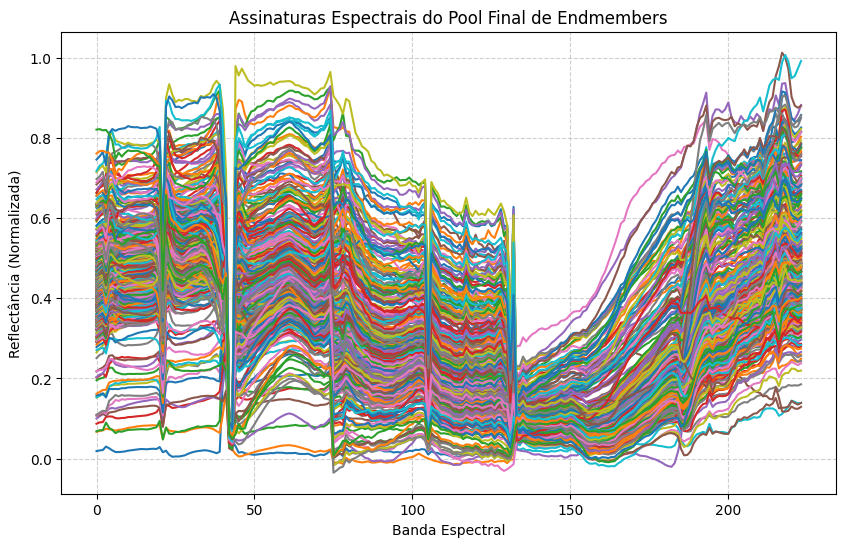

In [47]:
# Célula 8: Consolidação do Pool Total de Endmembers

# Certifique-se de que as variáveis endmembers_global_custom e local_endmembers_dict existem
if 'endmembers_global_custom' in locals() and 'local_endmembers_dict' in locals():
    print("Etapa de Consolidação: Combinando Endmembers Globais e Locais")

    # 1. Extrair todos os endmembers locais do dicionário para uma lista
    all_local_endmembers_list = []
    print("\nVerificando formato dos endmembers locais...")
    for segment_id, endmembers_array in local_endmembers_dict.items():
        # endmembers_array tem shape (num_endmembers_locais, num_bandas)
        if endmembers_array.shape[1] != b:
             print(f"  Aviso: Endmembers do segmento {segment_id} têm formato inesperado: {endmembers_array.shape}")
        for endmember in endmembers_array:
             all_local_endmembers_list.append(endmember)
        # Imprimir o formato do primeiro endmember local adicionado (para depuração)
        # if len(all_local_endmembers_list) > 0 and len(all_local_endmembers_list) <= p_local:
        #      print(f"  Primeiro endmember do segmento {segment_id} formato: {all_local_endmembers_list[-1].shape}")


    # Converter a lista de endmembers locais em um array NumPy
    if all_local_endmembers_list:
        all_local_endmembers = np.array(all_local_endmembers_list)
        print(f"\nTotal de endmembers locais extraídos: {all_local_endmembers.shape[0]}")
        print(f"Formato do array de endmembers locais: {all_local_endmembers.shape}")
    else:
        all_local_endmembers = np.array([]) # Array vazio se não houver endmembers locais
        print("Nenhum endmember local extraído.")


    # 2. Concatenar os endmembers globais e locais
    # Transpor endmembers_global_custom para que fique no formato (p_global, n_bandas)
    global_endmembers_transposed = endmembers_global_custom.T
    print(f"\nFormato de endmembers globais (transposto) antes da concatenação: {global_endmembers_transposed.shape}")

    if all_local_endmembers.size > 0:
        # global_endmembers_transposed tem shape (p_global, n_bandas)
        # all_local_endmembers tem shape (Total_locais, n_bandas)
        consolidated_endmember_pool = np.vstack((global_endmembers_transposed, all_local_endmembers))
        print(f"Shape inicial do pool consolidado (globais + locais): {consolidated_endmember_pool.shape}")
    else:
        consolidated_endmember_pool = global_endmembers_transposed.copy()
        print(f"Shape do pool consolidado (apenas globais): {consolidated_endmember_pool.shape}")


    # 3. Opcional: Remover endmembers duplicados ou espectralmente muito semelhantes
    # Esta é uma etapa importante na prática para reduzir redundância.
    # Implementação simples: remover duplicados exatos (se houver)
    # Para remover espectros semelhantes, seria necessário calcular similaridade espectral (ex: SAM)
    # e aplicar um limiar, o que é mais complexo e pode ser feito em uma etapa separada.

    # Remover linhas duplicadas exatas
    # Use np.unique com axis=0 para encontrar linhas únicas
    unique_endmembers, unique_indices = np.unique(consolidated_endmember_pool, axis=0, return_index=True)
    final_endmember_pool = unique_endmembers

    print(f"\nTotal de endmembers no pool final (após remover duplicados exatos): {final_endmember_pool.shape[0]}")


    print("\nConsolidação concluída.")
    print(f"Pool final de endmembers (shape): {final_endmember_pool.shape}")

    # Agora, 'final_endmember_pool' contém o conjunto consolidado de endmembers.

    # Opcional: Visualizar o pool final (pode ser grande!)
    plt.figure(figsize=(10, 6))
    for i in range(final_endmember_pool.shape[0]):
        plt.plot(final_endmember_pool[i, :]) # Sem labels individuais para evitar poluição visual
    plt.title('Assinaturas Espectrais do Pool Final de Endmembers')
    plt.xlabel('Banda Espectral')
    plt.ylabel('Reflectância (Normalizada)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()


else:
    print("Erro: As variáveis 'endmembers_global_custom' ou 'local_endmembers_dict' não foram criadas. Execute as células 6 e 7 primeiro.")

Etapa 3: Iniciando Agrupamento de Assinaturas Espectrais (Bundles)
Escalonando as assinaturas espectrais para o clustering...
Shape das assinaturas escalonadas: (393, 224)

Aplicando DBSCAN...
Agrupamento DBSCAN concluído.
Número estimado de bundles (clusters): 0
Número estimado de assinaturas de ruído (não agrupadas): 393

Análise e Visualização dos Bundles:


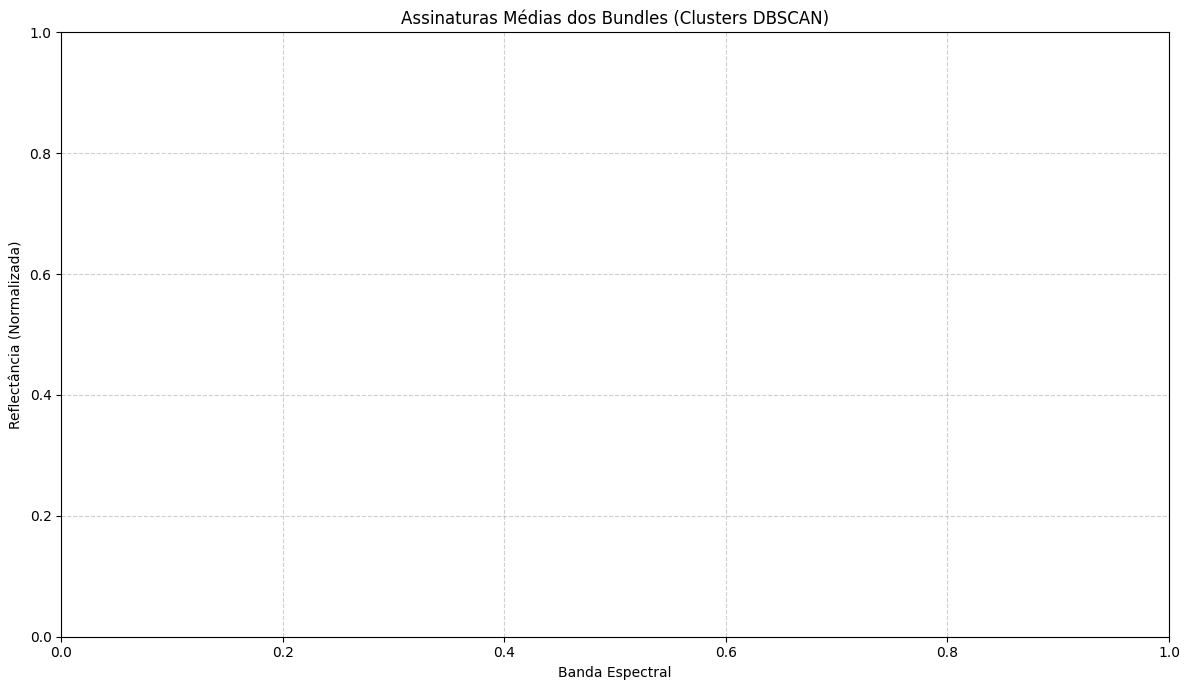


Visualizando clusters em 2D (PCA):


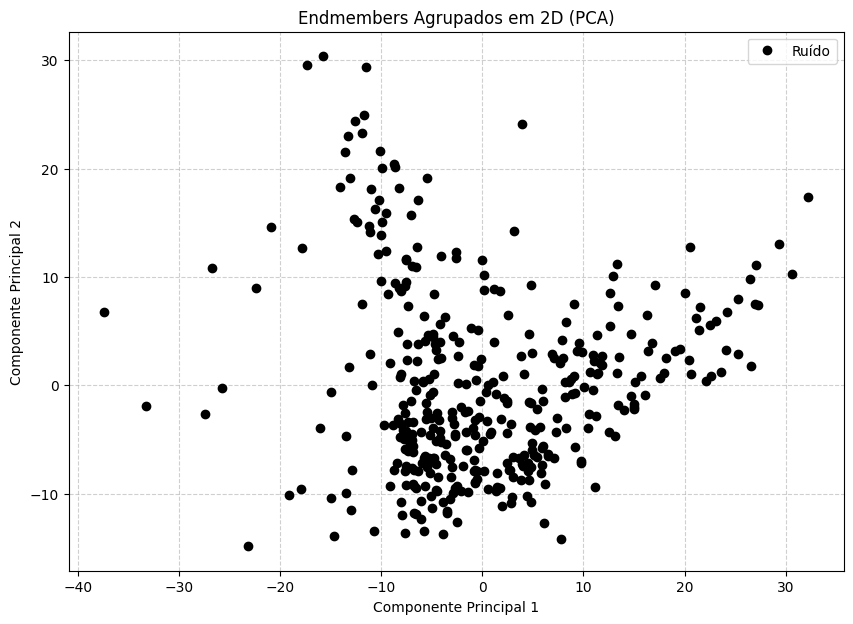

In [49]:
# Célula 9: Etapa 3: Agrupamento (Clustering) de Assinaturas Espectrais (Bundles)

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Certifique-se de que a variável final_endmember_pool existe
if 'final_endmember_pool' in locals() and final_endmember_pool is not None and final_endmember_pool.size > 0:
    print("Etapa 3: Iniciando Agrupamento de Assinaturas Espectrais (Bundles)")

    # 1. Opcional: Pré-processar os dados para o clustering (ex: normalização/escalonamento)
    # O DBSCAN é sensível à escala dos dados. Escalonar pode melhorar os resultados.
    print("Escalonando as assinaturas espectrais para o clustering...")
    scaler = StandardScaler()
    scaled_endmembers = scaler.fit_transform(final_endmember_pool)

    print(f"Shape das assinaturas escalonadas: {scaled_endmembers.shape}")


    # 2. Aplicar o algoritmo de clustering (DBSCAN)
    # DBSCAN requer dois parâmetros principais:
    #   - eps: A distância máxima entre duas amostras para que uma seja considerada como na vizinhança da outra.
    #   - min_samples: O número de amostras em uma vizinhança para que um ponto seja considerado um ponto central.
    # Estes parâmetros precisam ser ajustados experimentalmente!
    print("\nAplicando DBSCAN...")
    # Valores de exemplo para eps e min_samples. AJUSTE CONFORME NECESSÁRIO!
    dbscan = DBSCAN(eps=1.0, min_samples=5) # <-- Ajuste estes valores! Aumentado eps, ajustado min_samples
    cluster_labels = dbscan.fit_predict(scaled_endmembers)

    # Número de clusters encontrados (ignorando o ruído, rotulado como -1)
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    print(f"Agrupamento DBSCAN concluído.")
    print(f"Número estimado de bundles (clusters): {n_clusters}")
    print(f"Número estimado de assinaturas de ruído (não agrupadas): {n_noise}")


    # 3. Analisar e visualizar os resultados do clustering
    print("\nAnálise e Visualização dos Bundles:")

    unique_labels = set(cluster_labels)
    # Remove -1 do conjunto de labels para plotar apenas clusters
    if -1 in unique_labels:
        unique_labels.remove(-1)

    # Gere cores apenas para os clusters (rótulos > -1)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    # Opção A: Visualizar bundles (assinaturas médias por cluster)
    plt.figure(figsize=(12, 7))
    # Use um índice separado para as cores
    color_index = 0
    for k in sorted(list(unique_labels)): # Plota em ordem numérica dos bundles
        if k != -1:
            # Assinaturas de um bundle (cluster)
            class_members_mask = (cluster_labels == k)
            bundle_signatures = final_endmember_pool[class_members_mask]
            if len(bundle_signatures) > 0:
                 # Calcular a assinatura média do bundle
                mean_signature = np.mean(bundle_signatures, axis=0)
                # Use a cor correspondente do array de cores
                plt.plot(mean_signature, color=tuple(colors[color_index][:3]), label=f'Bundle {k}')
                color_index += 1 # Incrementa o índice de cor

    # Adicionar assinaturas de ruído (opcional, pode ser muito denso)
    # noise_mask = (cluster_labels == -1)
    # noise_signatures = final_endmember_pool[noise_mask]
    # for sig in noise_signatures:
    #     plt.plot(sig, color='gray', alpha=0.2) # Plotar ruído em cinza

    plt.title('Assinaturas Médias dos Bundles (Clusters DBSCAN)')
    plt.xlabel('Banda Espectral')
    plt.ylabel('Reflectância (Normalizada)')
    # Só mostra a legenda se houver bundles
    if unique_labels:
      plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


    # Opção B: Visualizar clusters em 2D (usando PCA nas assinaturas escalonadas)
    if scaled_endmembers.shape[0] > 2: # Precisa de pelo menos 3 amostras para PCA 2D
        print("\nVisualizando clusters em 2D (PCA):")
        pca_viz = PCA(n_components=2)
        principal_components = pca_viz.fit_transform(scaled_endmembers)

        plt.figure(figsize=(10, 7))
        # Use um índice separado para as cores
        color_index = 0
        for k in sorted(list(unique_labels) + [-1]): # Plota em ordem numérica dos bundles + ruído
            class_members_mask = (cluster_labels == k)
            xy = principal_components[class_members_mask]
            if k == -1:
                 # Cor preta para ruído
                plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor='k',
                         markeredgecolor='k', markersize=6, label='Ruído')
            else:
                # Use a cor correspondente do array de cores
                plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(colors[color_index][:3]),
                         markeredgecolor='k', markersize=6, label=f'Bundle {k}')
                color_index += 1 # Incrementa o índice de cor


        plt.title('Endmembers Agrupados em 2D (PCA)')
        plt.xlabel('Componente Principal 1')
        plt.ylabel('Componente Principal 2')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("\nNão há endmembers suficientes para visualização de clustering em 2D (PCA).")


    # Armazenar os resultados do clustering para uso posterior
    # cluster_labels contém o ID do cluster para cada endmember no final_endmember_pool
    # O pool consolidado e seus rótulos de cluster podem ser usados para análise posterior.


else:
    print("Erro: A variável 'final_endmember_pool' não foi criada ou está vazia. Execute a Célula 8 primeiro.")

In [50]:
# Célula 10: Seleção de Assinaturas Representativas dos Bundles

# Certifique-se de que as variáveis final_endmember_pool e cluster_labels existem
if 'final_endmember_pool' in locals() and final_endmember_pool is not None and 'cluster_labels' in locals():
    print("Iniciando Seleção de Assinaturas Representativas dos Bundles")

    unique_labels = set(cluster_labels)
    # Excluir o rótulo de ruído (-1) se ele existir
    if -1 in unique_labels:
        unique_labels.remove(-1)

    representative_signatures = []
    representative_labels = []

    print(f"Calculando assinaturas médias para {len(unique_labels)} bundles...")

    for k in unique_labels:
        # Selecionar endmembers que pertencem ao cluster atual (k)
        class_members_mask = (cluster_labels == k)
        bundle_endmembers = final_endmember_pool[class_members_mask]

        if len(bundle_endmembers) > 0:
            # Calcular a assinatura média do bundle
            mean_signature = np.mean(bundle_endmembers, axis=0)
            representative_signatures.append(mean_signature)
            representative_labels.append(f'Bundle {k}')
            # Opcional: Imprimir o número de endmembers neste bundle
            # print(f"  Bundle {k}: {len(bundle_endmembers)} endmembers")

    # Converter a lista de assinaturas representativas em um array NumPy
    if representative_signatures:
        representative_signatures_array = np.array(representative_signatures)
        print(f"\nSeleção concluída.")
        print(f"Shape do array de assinaturas representativas: {representative_signatures_array.shape}")
    else:
        representative_signatures_array = np.array([])
        print("\nNenhuma assinatura representativa calculada (verifique os resultados do clustering).")


    # Visualizar as assinaturas representativas
    if representative_signatures_array.size > 0:
        plt.figure(figsize=(12, 7))
        for i in range(representative_signatures_array.shape[0]):
            plt.plot(representative_signatures_array[i, :], label=representative_labels[i])

        plt.title('Assinaturas Espectrais Representativas dos Bundles')
        plt.xlabel('Banda Espectral')
        plt.ylabel('Reflectância (Normalizada)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
    else:
        print("Não há assinaturas representativas para visualizar.")


else:
    print("Erro: As variáveis 'final_endmember_pool' ou 'cluster_labels' não foram criadas. Execute as células 8 e 9 primeiro.")

Iniciando Seleção de Assinaturas Representativas dos Bundles
Calculando assinaturas médias para 0 bundles...

Nenhuma assinatura representativa calculada (verifique os resultados do clustering).
Não há assinaturas representativas para visualizar.


In [51]:
# Célula 11: Classificação usando Spectral Angle Mapper (SAM)

# Certifique-se de que as variáveis img_denoised_list e representative_signatures_array existem
if 'img_denoised_list' in locals() and img_denoised_list and 'representative_signatures_array' in locals() and representative_signatures_array.size > 0:
    print("Iniciando Classificação SAM para todas as imagens")

    num_bundles = representative_signatures_array.shape[0]

    if num_bundles == 0:
        print("Erro: Não há assinaturas representativas de bundles para usar na classificação SAM.")
    else:
        print(f"Usando {num_bundles} assinaturas representativas de bundles para classificação SAM.")

        # Itera sobre cada imagem na lista de imagens sem ruído
        for i, img_denoised in enumerate(img_denoised_list):

            print(f"\n--- Classificando Imagem {i+1} / {len(img_denoised_list)} usando SAM ---")

            h, w, b = img_denoised.shape

            # Inicializar o mapa de classificação para a imagem atual
            classification_map = np.zeros((h, w), dtype=int)
            # Inicializar um mapa para armazenar o menor ângulo espectral para cada pixel (opcional)
            min_angles_map = np.full((h, w), np.inf, dtype=np.float32)


            print("Calculando ângulos espectrais e classificando cada pixel (pode levar algum tempo)...")
            # Percorrer cada pixel na imagem atual
            for row in range(h):
                for col in range(w):
                    pixel_spectrum = img_denoised[row, col, :]

                    # Calcular o ângulo espectral entre o pixel e cada assinatura representativa do bundle
                    min_angle = np.inf
                    best_match_bundle_index = -1 # Usaremos o índice 0-based dos bundles aqui

                    # Percorrer cada assinatura representativa do bundle
                    for bundle_index in range(num_bundles):
                        bundle_signature = representative_signatures_array[bundle_index, :]

                        # Calcular a similaridade do cosseno primeiro
                        dot_product = np.dot(pixel_spectrum, bundle_signature)
                        norm_pixel = np.linalg.norm(pixel_spectrum)
                        norm_bundle = np.linalg.norm(bundle_signature)

                        # Evitar divisão por zero se um espectro for zero
                        if norm_pixel > 0 and norm_bundle > 0:
                            cosine_similarity = dot_product / (norm_pixel * norm_bundle)
                            # O ângulo espectral é o arccos da similaridade do cosseno
                            # Cuidado com valores que podem estar ligeiramente fora do intervalo [-1, 1] devido a erros de ponto flutuante
                            cosine_similarity = np.clip(cosine_similarity, -1.0, 1.0)
                            spectral_angle = np.arccos(cosine_similarity) # Ângulo em radianos

                            # Verificar se este é o menor ângulo encontrado até agora
                            if spectral_angle < min_angle:
                                min_angle = spectral_angle
                                best_match_bundle_index = bundle_index

                    # Atribuir o rótulo do bundle com o menor ângulo espectral ao pixel
                    # Usaremos o índice do array representative_signatures_array como rótulo (+1 para rótulos 1-based)
                    classification_map[row, col] = best_match_bundle_index + 1 # Rótulos 1-based

                    # Armazenar o menor ângulo (opcional para análise posterior)
                    min_angles_map[row, col] = min_angle


            print(f"Classificação SAM concluída para Imagem {i+1}.")

            # 3. Visualizar o mapa de classificação para a imagem atual
            plt.figure(figsize=(10, 8))
            # Use um mapa de cores discreto para as classes
            cmap = plt.get_cmap('viridis', num_bundles + 1) # +1 para incluir a cor 0 ou fundo
            plt.imshow(classification_map, cmap=cmap)
            plt.title(f'Mapa de Classificação SAM - Imagem {i+1}')
            plt.colorbar(label='Bundle/Classe')
            plt.axis('off')
            plt.show()

        print("\n--- Classificação SAM para todas as imagens concluída. ---")

else:
    print("Erro: A lista 'img_denoised_list' ou o array 'representative_signatures_array' não foram criados ou estão vazios. Execute as células anteriores (4, 8, 9, 10).")

Erro: A lista 'img_denoised_list' ou o array 'representative_signatures_array' não foram criados ou estão vazios. Execute as células anteriores (4, 8, 9, 10).


# Task
Implement a physics-informed autoencoder to produce pure pixels from VCA results in an empty cell.

## Preparação dos dados

### Subtask:
Preparar os dados de entrada para o autoencoder, que serão as assinaturas espectrais dos pixels.


**Reasoning**:
Check if the denoised image exists and is not empty, then reshape it into a 2D array where each row is a pixel spectrum, and print the shape of the resulting array.



In [ ]:
# Célula para preparar os dados para o autoencoder

# 1. Verifique se a variável img_denoised existe e não está vazia
if 'img_denoised' in locals() and img_denoised is not None and img_denoised.size > 0:
    print("Variável 'img_denoised' encontrada. Preparando dados para o autoencoder...")

    # 2. Remodele o array img_denoised para ter a forma (número total de pixels, número de bandas)
    h, w, b = img_denoised.shape
    pixel_spectra = img_denoised.reshape(-1, b)

    # 3. Imprima a forma do array pixel_spectra
    print(f"Shape dos dados de entrada para o autoencoder (pixel_spectra): {pixel_spectra.shape}")

else:
    print("Erro: A variável 'img_denoised' não foi criada ou está vazia. Execute as células anteriores para carregar e pré-processar a imagem.")
